In [197]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio
import math
import sys
from matplotlib.patches import Polygon

from CST import CST
from Node import Node
from units import mm, cm, m, kgf, N, tf, kN, MPa, GPa, kg
from fem import Material, Membrane
from functions import matrix_extract,  get_nodes_from_physical_id, get_line_load_global_vector, matrix_replace


In [198]:
geo_file = "prueba_2025.geo"
lc = 5
gmsh.initialize()
gmsh.open(geo_file)
gmsh.model.geo.synchronize()
# Inicializar Gmsh
gmsh.initialize()

# Cargar archivo .geo
gmsh.open(geo_file)

# Establecer parámetros de mallado
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)

# Sincronizar (por si hay geometría a modificar, aunque ya fue cargada)
gmsh.model.geo.synchronize()

# Generar la malla (2 = malla 2D, 3 = malla 3D)
gmsh.model.mesh.generate(3)

# Exportar la malla a archivo .msh si lo deseas
output_file = 'malla.msh'
gmsh.write(output_file)

# Visualizar
gmsh.fltk.run()

gmsh.finalize()


In [199]:
Concrete_M=Material.Material(name='Concrete',
             E=47*(40*MPa)**0.5,
             nu=0.17,
             rho=2.500)

# Definimos una seccion de la membrana
Concrete=Membrane.Membrane(name='Concrete',
              thickness=1*m,
              material=Concrete_M)


# Definimos los grupos fisicos de las partes del modelo
# Map the physical group id to a section
section_dict={"Concrete":Concrete}

In [200]:
mesh = meshio.read(output_file)

for i, (cell_block, phys_ids) in enumerate(zip(mesh.cells, mesh.cell_data["gmsh:physical"])):
    print(f"Block {i} - Tipo: {cell_block.type}, Cantidad: {len(cell_block.data)}, Physical tags: {set(phys_ids)}")


Block 0 - Tipo: line, Cantidad: 44, Physical tags: {np.int64(125)}
Block 1 - Tipo: line, Cantidad: 12, Physical tags: {np.int64(125)}
Block 2 - Tipo: line, Cantidad: 32, Physical tags: {np.int64(123)}
Block 3 - Tipo: triangle, Cantidad: 3498, Physical tags: {np.int64(201)}


In [201]:
mesh = meshio.read(output_file)

# Asociación de tag físico con nombre
tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}

# Diccionario {nombre_grupo: [Node, Node, ...]}
grupos = {}
Materials = {}
# Procesar elementos tipo triangle
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "triangle":
        continue
    for tri, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")

        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in tri:
            x, y = mesh.points[node_id][:2]
            grupos[nombre].append(Node(node_id+1, (x, y)))


# Procesar elementos tipo line (para grupos como "Fuerza")
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "line":
        continue
    for line, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in line:
            x, y = mesh.points[node_id][:2]
            restrain = ["f", "f"]

            if nombre in ["BC_1"]:
                print(f"Grupo {nombre} - Nodo {node_id+1} - Coordenadas ({x}, {y})")
                restrain = ["r", "r"]
            grupos[nombre].append(Node(node_id+1, (x, y), restrain=restrain))


   


# Eliminar nodos duplicados por grupo
for nombre in grupos:
    nodos_unicos = {}
    for n in grupos[nombre]:
        nodos_unicos[n.name] = n
    grupos[nombre] = list(nodos_unicos.values())
    print(f"Grupo {nombre} - Cantidad de nodos: {len(grupos[nombre])}")
print(len(grupos["BC_1"]))



Grupo BC_1 - Nodo 7 - Coordenadas (0.0, 160.0)
Grupo BC_1 - Nodo 144 - Coordenadas (0.0, 155.0)
Grupo BC_1 - Nodo 144 - Coordenadas (0.0, 155.0)
Grupo BC_1 - Nodo 145 - Coordenadas (0.0, 150.0)
Grupo BC_1 - Nodo 145 - Coordenadas (0.0, 150.0)
Grupo BC_1 - Nodo 146 - Coordenadas (0.0, 145.0)
Grupo BC_1 - Nodo 146 - Coordenadas (0.0, 145.0)
Grupo BC_1 - Nodo 147 - Coordenadas (0.0, 140.0)
Grupo BC_1 - Nodo 147 - Coordenadas (0.0, 140.0)
Grupo BC_1 - Nodo 148 - Coordenadas (0.0, 135.0)
Grupo BC_1 - Nodo 148 - Coordenadas (0.0, 135.0)
Grupo BC_1 - Nodo 149 - Coordenadas (0.0, 130.0)
Grupo BC_1 - Nodo 149 - Coordenadas (0.0, 130.0)
Grupo BC_1 - Nodo 150 - Coordenadas (0.0, 125.0)
Grupo BC_1 - Nodo 150 - Coordenadas (0.0, 125.0)
Grupo BC_1 - Nodo 151 - Coordenadas (0.0, 120.0)
Grupo BC_1 - Nodo 151 - Coordenadas (0.0, 120.0)
Grupo BC_1 - Nodo 152 - Coordenadas (0.0, 115.0)
Grupo BC_1 - Nodo 152 - Coordenadas (0.0, 115.0)
Grupo BC_1 - Nodo 153 - Coordenadas (0.0, 110.0)
Grupo BC_1 - Nodo 153

In [202]:
nodes_dict = {}
for group in grupos:
    for node in grupos[group]:
        nodes_dict[node.name] = node

In [203]:
triangles = mesh.cells_dict['triangle']
tags = mesh.cell_data_dict["gmsh:physical"]["triangle"]
elements = []
nodes = set()

for i in range(len(tags)):
    tag = tags[i]
    group_name = tag_to_name[tag]

    material= section_dict[group_name]
    node_ids = triangles[i]
    nodo_a = nodes_dict[node_ids[0]+1]
    nodo_b = nodes_dict[node_ids[1]+1]
    nodo_c = nodes_dict[node_ids[2]+1]



    for nodo in [nodo_a, nodo_b, nodo_c]:
        nodes.add(nodo)
        if np.all(nodo.restrain == ["r", "r"]):
            print(f"Nodo {nodo.name} con restricción total está en elemento {i+1}")


    elem = CST(i+1, [nodo_a, nodo_b, nodo_c], section=material)
    elements.append(elem)

nodes = list(nodes)


Nodo 155 con restricción total está en elemento 2
Nodo 154 con restricción total está en elemento 2
Nodo 174 con restricción total está en elemento 9
Nodo 154 con restricción total está en elemento 21
Nodo 155 con restricción total está en elemento 43
Nodo 174 con restricción total está en elemento 65
Nodo 1 con restricción total está en elemento 65
Nodo 174 con restricción total está en elemento 69
Nodo 157 con restricción total está en elemento 119
Nodo 156 con restricción total está en elemento 119
Nodo 157 con restricción total está en elemento 174
Nodo 156 con restricción total está en elemento 175
Nodo 173 con restricción total está en elemento 464
Nodo 172 con restricción total está en elemento 464
Nodo 171 con restricción total está en elemento 513
Nodo 170 con restricción total está en elemento 513
Nodo 165 con restricción total está en elemento 557
Nodo 163 con restricción total está en elemento 572
Nodo 168 con restricción total está en elemento 634
Nodo 167 con restricción 

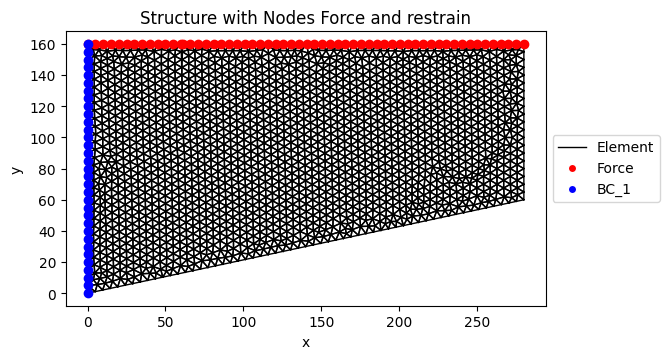

In [204]:
x = np.array([node.coordenadas[0] for node in nodes])
y = np.array([node.coordenadas[1] for node in nodes])

# Mapeo name → índice
node_index_map = {node.name: i for i, node in enumerate(nodes)}

# Gráfico
fig, ax = plt.subplots(figsize=(8, 6))

for elem in elements:
    indices = [node_index_map[node.name] for node in elem.node_list]
    coords = np.array([[x[i], y[i]] for i in indices + [indices[0]]])
    ax.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

# Dibujar nodos del grupo "Force" (en rojo)
for i, node in enumerate(grupos["BC_F"]):
    idx = node_index_map[node.name]
    ax.plot(x[idx], y[idx], 'ro', markersize=6, label="Carga (Force)" if i == 0 else "")


for i, node in enumerate(grupos["BC_1"]):
    idx = node_index_map[node.name]
    ax.plot(x[idx], y[idx], 'bo', markersize=6, label="Apoyo (BC_1)" if i == 0 else "")

# Gráfico final
ax.set_title("Structure with Nodes Force and restrain")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")

ax.legend(
    handles=[
        plt.Line2D([0], [0], color='k', lw=1, label='Element'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=6, label='Force'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=6, label='BC_1')
    ],
    loc="center left",
    bbox_to_anchor=(1.0, 0.5)  # 📌 esto lo pone fuera del eje
)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [205]:
def solve(nodes, elements):
    """
    Resuelve el sistema FEM considerando cargas distribuidas en líneas.

    Args:
        nodes (list): Lista de nodos con .idx, .nodalLoad, .restrain
        elements (list): Lista de elementos con .kg, .idx
        mesh: Objeto meshio con malla y etiquetas físicas
        load_dictionary (dict): Dict {id_físico: valor_carga}

    Returns:
        u (np.ndarray): Desplazamientos globales
        F_reactions (np.ndarray): Reacciones en DOFs restringidos
        Fj (np.ndarray): Fuerzas nodales aplicadas
        F_total (np.ndarray): Fuerzas totales incluyendo reacciones
    """
    nNodes = len(nodes)
    system_nDof = 2 * nNodes  # 2 DOFs por nodo

    # === CARGAS DISTRIBUIDAS EN LÍNEAS ===
    F_line_global = np.zeros(system_nDof)
    Fj = np.zeros(system_nDof)
    for node in nodes:
        for dof_idx, force in zip(node.idx, node.nodalLoad):
            Fj[dof_idx] = force



    # === MATRIZ DE RIGIDEZ GLOBAL ===
    Kg = np.zeros((system_nDof, system_nDof))
    for element in elements:
        Kg = matrix_replace(Kg, element.kg, element.idx, element.idx)


    # === RESTRICCIONES ===
    nodeIndex = np.full(system_nDof, '', dtype=str)
    for node in nodes:
        for dof_idx, status in zip(node.idx, node.restrain):
            nodeIndex[dof_idx] = status

    freeIndices = np.where(nodeIndex == 'f')[0]
    restrainedIndices = np.where(nodeIndex == 'r')[0]

    # === PARTICIÓN DEL SISTEMA ===
    Kff = matrix_extract(Kg, freeIndices, freeIndices)
    Kfr = matrix_extract(Kg, freeIndices, restrainedIndices)
    Krf = matrix_extract(Kg, restrainedIndices, freeIndices)
    Krr = matrix_extract(Kg, restrainedIndices, restrainedIndices)

    # === FUERZA TOTAL (aplicada + distribuida) ===
    F = Fj + F_line_global
    Ff = F[freeIndices]
    Fr = F[restrainedIndices]

    # === SOLUCIÓN ===
    uf = np.linalg.solve(Kff, Ff - Kfr @ Fr)
    ur = np.zeros(len(restrainedIndices))

    u = np.zeros(system_nDof)
    u[freeIndices] = uf
    u[restrainedIndices] = ur


    # === REACCIONES ===
    Fr = Krf @ uf + Krr @ ur
    F_reactions = np.zeros(system_nDof)
    F_reactions[restrainedIndices] = Fr


    return u, Fr

In [206]:
def apply_distributed_force(grupo_nodos, fuerza_total_y):
    """
    Aplica una fuerza distribuida vertical (por ejemplo, peso) sobre una línea formada por nodos no alineados.
    La fuerza se reparte proporcionalmente a la longitud de los tramos y se descompone en x e y.
    """

    # Paso 1: ordena nodos si es necesario (aquí asumimos que ya están ordenados)
    nodos = grupo_nodos
    n = len(nodos)
    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Paso 2: calcular longitud total de la línea
    longitudes = []
    total_length = 0
    for i in range(n - 1):
        dx = nodos[i+1].coordenadas[0]- nodos[i].coordenadas[0]
        dy = nodos[i+1].coordenadas[1] - nodos[i].coordenadas[0]
        L = np.sqrt(dx**2 + dy**2)
        longitudes.append(L)
        total_length += L

    # Paso 3: calcular carga distribuida por unidad de longitud
    q_total = fuerza_total_y  # Fuerza total a repartir
    q_lineal = q_total / total_length  # N/m

    # Paso 4: aplicar cargas parciales a cada nodo (2 nodos por segmento)
    nodal_forces = {node.name: np.array([0.0, 0.0]) for node in nodos}

    for i in range(n - 1):
        ni = nodos[i]
        nj = nodos[i + 1]
        xi, yi = ni.coordenadas[0], ni.coordenadas[1]
        xj, yj = nj.coordenadas[0], nj.coordenadas[1]

        dx = xj - xi
        dy = yj - yi
        L = longitudes[i]

        # Dirección normalizada del tramo (unitario)
        vx = dx / L
        vy = dy / L

        # Vector perpendicular (hacia abajo)
        nx = -vy
        ny = vx

        # Fuerza total sobre el tramo
        Fi = q_lineal * L  # Total fuerza sobre el tramo

        # Componente de fuerza en x y y (globales)
        fx = Fi * nx
        fy = Fi * ny

        # Distribuir mitad a cada nodo
        nodal_forces[ni.name] += np.array([fx / 2, fy / 2])
        nodal_forces[nj.name] += np.array([fx / 2, fy / 2])
    for node in nodos:
        fx, fy = nodal_forces[node.name]
        dof_x, dof_y = node.idx
        node.set_nodalLoad([fx,fy])

In [207]:
def plot_deformed_shape(nodes, elements, u, scale):
    """
    Dibuja la estructura deformada y original, marcando nodos cargados y restringidos.

    Args:
        nodes (list): lista de nodos con .coordenadas, .name, .idx
        elements (list): lista de elementos con .node_list
        u (np.ndarray): vector de desplazamientos global
        contador (int): índice del caso (0, 1, 2)
        scale (float): factor de amplificación de la deformación
    """
    filename = None
    # Inicializar vectores de coordenadas
    n = len(nodes)
    x = np.zeros(n)
    y = np.zeros(n)
    x_def = np.zeros(n)
    y_def = np.zeros(n)

    # Construcción coordenadas originales y deformadas usando node.idx
    for i, node in enumerate(nodes):
        x[i] = node.coordenadas[0]
        y[i] = node.coordenadas[1]
        x_def[i] = x[i] + scale * u[node.idx[0]]
        y_def[i] = y[i] + scale * u[node.idx[1]]

    # Mapeo name → índice en array
    node_index_map = {node.name: i for i, node in enumerate(nodes)}


    # Gráfico
    fig, ax = plt.subplots(figsize=(8, 6))

    # Estructura original (negro)
    for elem in elements:
        indices = [node_index_map[node.name] for node in elem.node_list]
        coords = np.array([[x[i], y[i]] for i in indices + [indices[0]]])
        ax.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

    # Estructura deformada (rojo punteado)
    for elem in elements:
        indices = [node_index_map[node.name] for node in elem.node_list]
        coords = np.array([[x_def[i], y_def[i]] for i in indices + [indices[0]]])
        ax.plot(coords[:, 0], coords[:, 1], 'r--', linewidth=1)





    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

    # Leyenda fuera del gráfico
    ax.legend(
        handles=[
            plt.Line2D([0], [0], color='k', lw=1, label='Elemento'),
            plt.Line2D([0], [0], linestyle='--', color='r', lw=1, label='Deformada')
        ],
        loc="center left",
        bbox_to_anchor=(1.02, 0.5)
    )

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [208]:
def ensure_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
def compute_stress_strain_components(elements, u):
    results = []

    for elem in elements:
        # Obtener tensiones y deformaciones
        sigma, epsilon, _ = elem.get_element_stress(u)  # σxx, σyy, σxy
        exx, eyy, exy = epsilon
        sxx, syy, sxy = sigma

        # Deformaciones principales
        avg_eps = 0.5 * (exx + eyy)
        rad_eps = np.sqrt(((exx - eyy) / 2) ** 2 + exy ** 2)
        eps1 = avg_eps + rad_eps
        eps2 = avg_eps - rad_eps

        # Tensiones principales
        avg_sig = 0.5 * (sxx + syy)
        rad_sig = np.sqrt(((sxx - syy) / 2) ** 2 + sxy ** 2)
        sig1 = avg_sig + rad_sig
        sig2 = avg_sig - rad_sig

        results.append({
            "element": elem.element_tag,
            "σxx": sxx, "σyy": syy, "σxy": sxy,
            "εxx": exx, "εyy": eyy, "εxy": exy,
            "σ1": sig1, "σ2": sig2,
            "ε1": eps1, "ε2": eps2
        })

    return results
def average_element_values_to_nodes(nodes, elements, element_values):
    """
    Convierte valores definidos por elemento (por ejemplo σ1) en valores nodales por promedio.
    """
    from collections import defaultdict

    # Suma de valores y conteo
    val_sum = defaultdict(float)
    val_count = defaultdict(int)

    for elem, val in zip(elements, element_values):
        for node in elem.node_list:
            val_sum[node.name] += val
            val_count[node.name] += 1

    # Asignar promedio a cada nodo
    node_id_to_avg = {
        nid: val_sum[nid] / val_count[nid] for nid in val_sum
    }

    # Generar array en orden de nodos
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}
    nodal_values = np.array([
        node_id_to_avg[node.name] for node in nodes
    ])

    return nodal_values
import matplotlib.tri as mtri
def plot_scalar_field_on_mesh(nodes, elements, values, title, folder="figuras", filename=None, cmap="viridis"):
    """
    nodes: lista de nodos (cada uno con .id, .x, .y)
    elements: lista de elementos CST (con .node_list)
    values: lista de valores escalares por elemento (1 valor por elemento)
    """
    # Mapear ids de nodo a índice
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}

    # Coordenadas
    xs = [node.coordenadas[0] for node in nodes]
    ys = [node.coordenadas[1] for node in nodes]

    # Triángulos como lista de índices
    triangles = [
        [node_id_to_index[n.name] for n in elem.node_list]
        for elem in elements
    ]

    # Valor por triángulo → convertir a array
    values = np.array(values)

    # Crear triangulación
    triang = mtri.Triangulation(xs, ys, triangles)

    # Graficar
    plt.figure(figsize=(8, 6))
    tcf = plt.tricontourf(triang, values, cmap=cmap)
    plt.colorbar(tcf, label=title)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect("equal")
    plt.tight_layout()

    # Guardar imagen
    ensure_dir(folder)
    if filename is None:
        filename = title.replace(" ", "_").replace("—", "-") + ".png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath, dpi=300)

def plot_all_fields(results, nodes, elements, i):
    fields = ["σxx", "σyy", "σxy", "σ1", "σ2", "εxx", "εyy", "εxy", "ε1", "ε2"]
    titles = {
        "σxx": "Stress σxx", "σyy": "Stress σyy", "σxy": "Stress τxy",
        "σ1": "Maximum Principal Stress σ1", "σ2": "Minimum Principal Stress σ2",
        "εxx": "Strain εxx", "εyy": "Strain εyy", "εxy": "Strain εxy",
        "ε1": "Maximum Principal Strain ε1", "ε2": "Minimum Principal Strain ε2"
    }

    caso = f"Case {i+1}"

    for field in fields:
        element_values = [res[field] for res in results]
        nodal_values = average_element_values_to_nodes(nodes, elements, element_values)
        plot_scalar_field_on_mesh(nodes, elements, nodal_values, f"{caso} — {titles[field]}", folder="Resultados")


In [209]:
def plot_deformed_shape_with_strain_field(nodes, elements, u, results, field="εeq", scale=1.0, cmap="plasma"):
    """
    Dibuja la forma deformada con mapa de calor de deformaciones.

    Args:
        nodes: lista de nodos con .coordenadas y .idx
        elements: lista de elementos con .node_list
        u: vector de desplazamientos global
        results: lista de diccionarios con campos de deformaciones por elemento
        field: campo a visualizar ("εxx", "εyy", "εxy", "εeq", etc.)
        scale: factor de amplificación de la deformación
        cmap: colormap para visualización
    """

    # Coordenadas originales y deformadas
    x_def, y_def = [], []
    for node in nodes:
        x = node.coordenadas[0]
        y = node.coordenadas[1]
        dx = scale * u[node.idx[0]]
        dy = scale * u[node.idx[1]]
        x_def.append(x + dx)
        y_def.append(y + dy)

    # Asignar valores escalares por nodo
    if field == "εeq":
        # Calcular deformación equivalente von Mises 2D para cada elemento
        element_values = [
            np.sqrt(res["εxx"]**2 + res["εyy"]**2 + 2 * res["εxy"]**2)
            for res in results
        ]
    else:
        element_values = [res[field] for res in results]

    nodal_values = average_element_values_to_nodes(nodes, elements, element_values)

    # Triangulación para graficar en matplotlib.tri
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}
    triangles = [
        [node_id_to_index[n.name] for n in elem.node_list]
        for elem in elements
    ]

    triang = mtri.Triangulation(x_def, y_def, triangles)

    # Graficar
    plt.figure(figsize=(8, 6))
    tcf = plt.tricontourf(triang, nodal_values, cmap=cmap)
    plt.triplot(triang, color="gray", linewidth=0.3, alpha=0.5)
    plt.colorbar(tcf, label=field)
    plt.title(f"Deformed Shape + Heatmap of {field}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    plt.show()

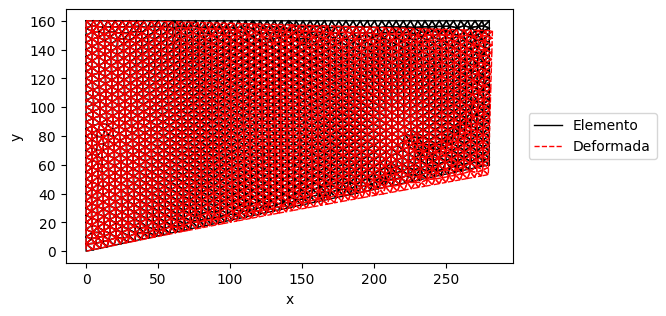

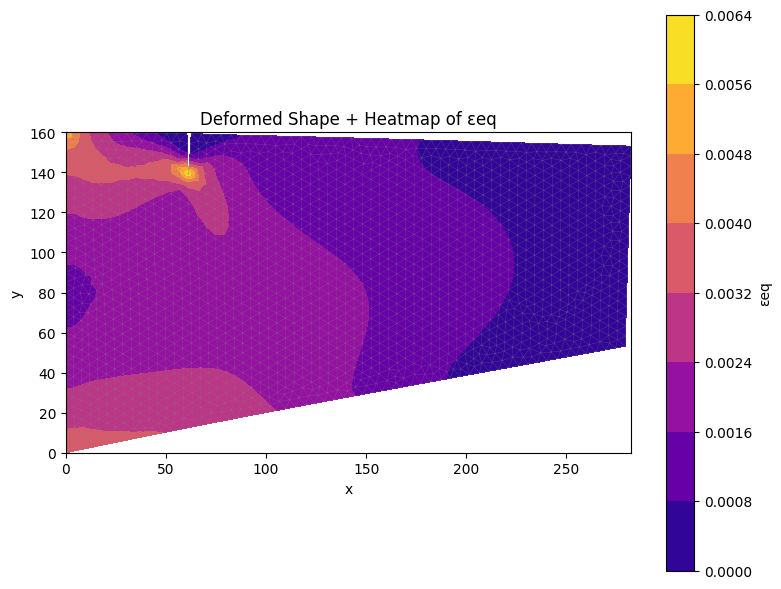

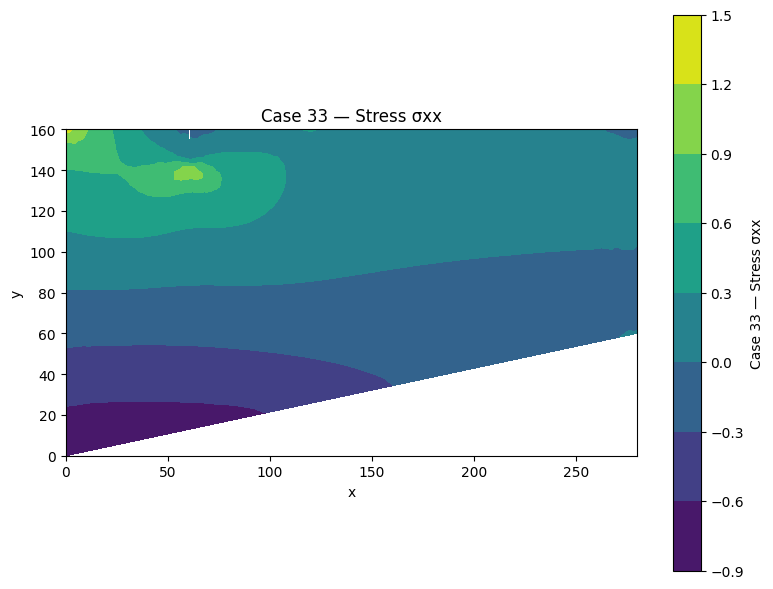

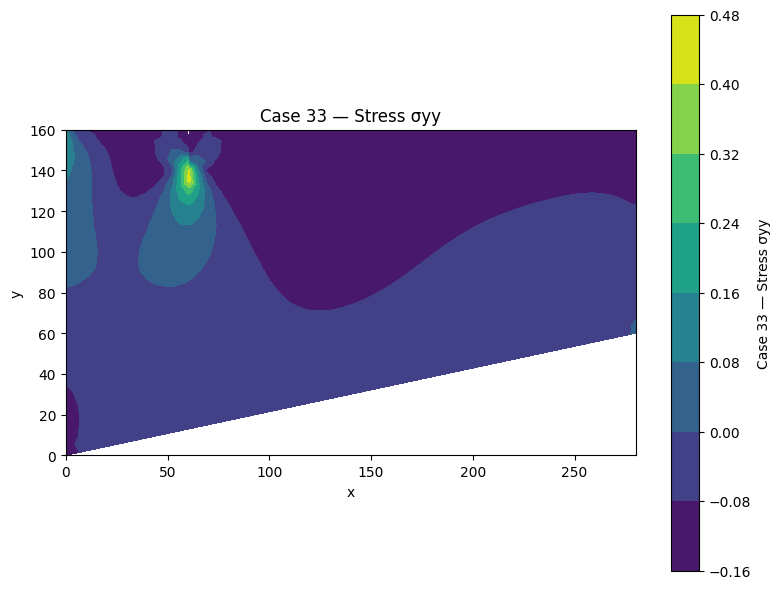

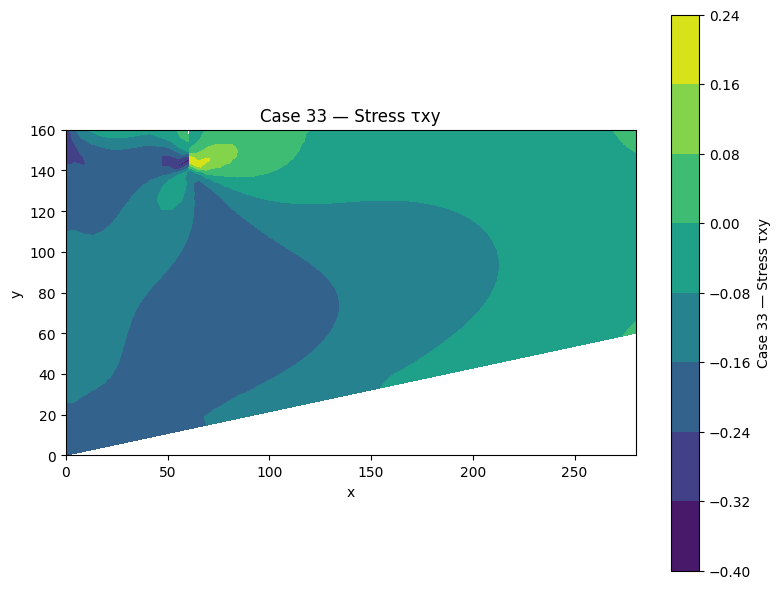

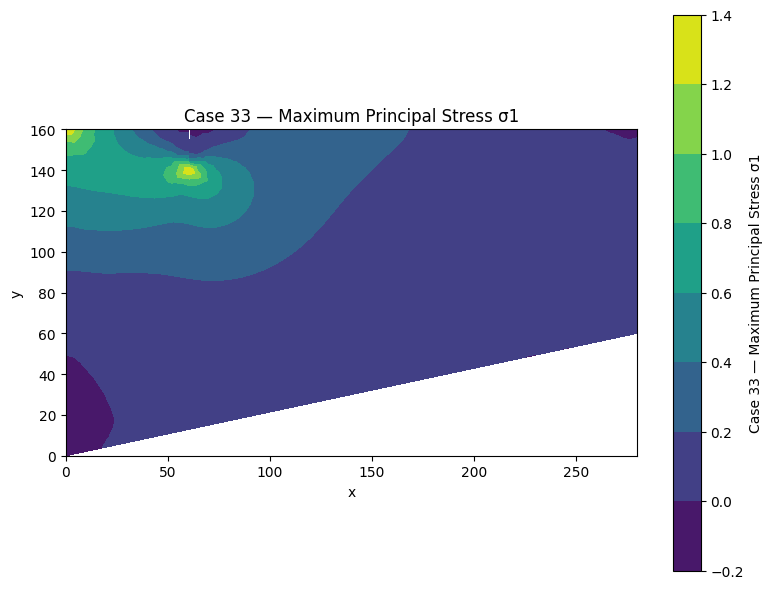

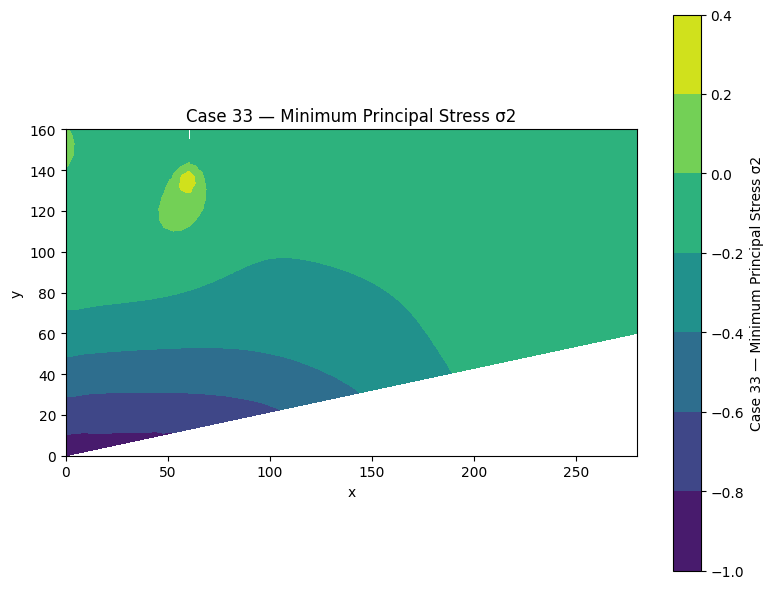

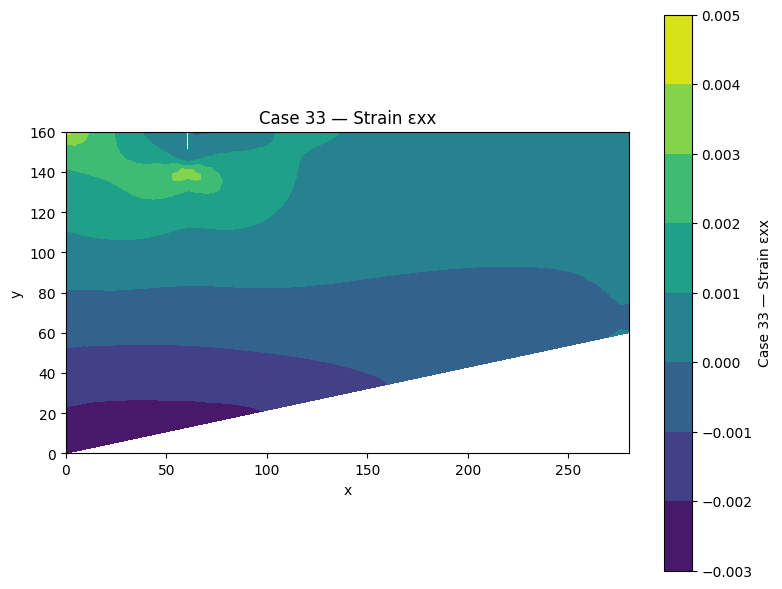

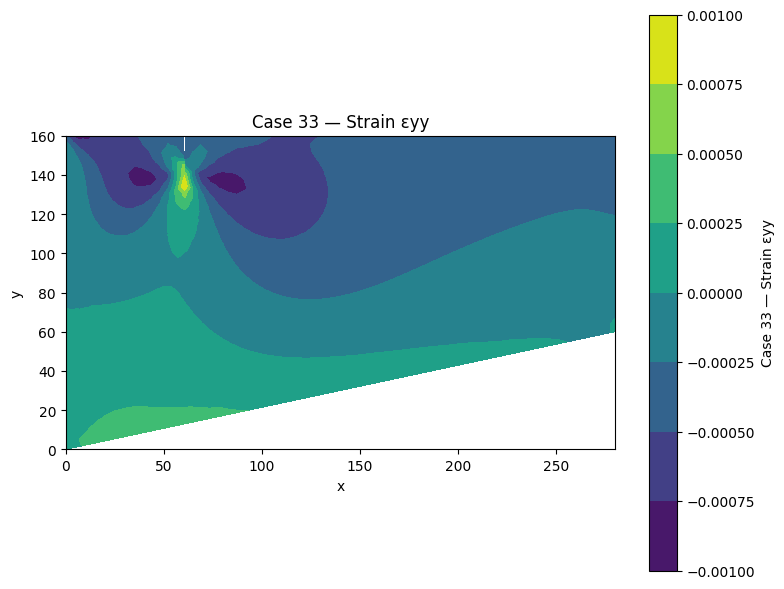

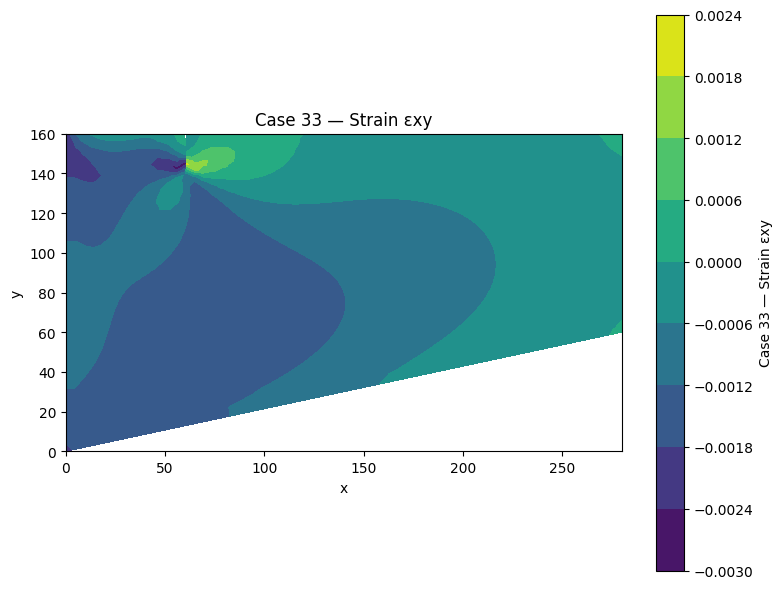

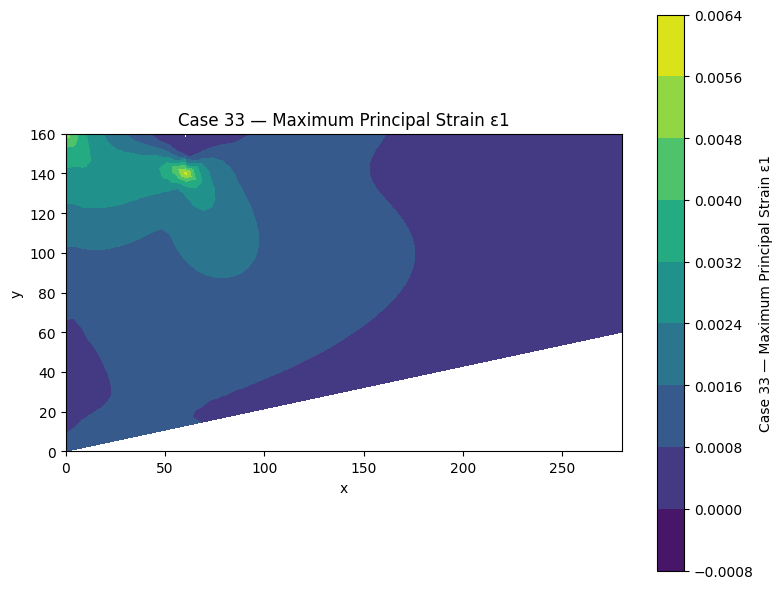

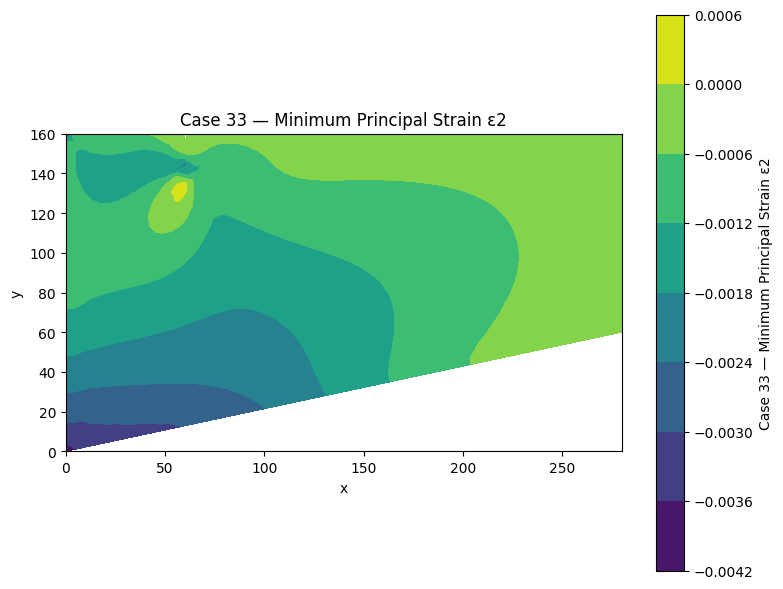

In [210]:
if "BC_F" in grupos:
    nodos_fuerza = grupos["BC_F"]
apply_distributed_force(nodos_fuerza, fuerza_total_y=400*kN)
u, F_reactions=solve(nodes, elements)
plot_deformed_shape(nodes, elements, u, scale=5)
results = compute_stress_strain_components(elements, u)
plot_deformed_shape_with_strain_field(nodes, elements, u, results, field="εeq", scale=5)
plot_all_fields(results, nodes, elements, i)


In [211]:
fc_crit= 0.35*(40*MPa)**0.5
print(f"fc_crit: {fc_crit} MPa")

print(F_reactions)

fc_crit: 2.2135943621178655 MPa
[ 2385.24659254   872.14083004 -4137.18870305   995.07379016
 -4860.69142582  1292.10935619 -3836.81789249  1192.85426761
 -3300.71111387  1178.83179885 -2937.20660676  1131.3268603
 -2656.59287871  1073.24578142 -2418.21173471  1010.8193876
 -2194.4821912    946.1826243  -1967.35630081   880.33699899
 -1732.3595823    817.04953768 -1492.58097445   765.88243764
 -1242.06703031   722.62196501  -977.11422849   681.69511382
  -721.44884988   659.01709368  -450.1714882    632.98235296
  -181.59932548   628.82473045    81.81823365   621.25779536
   350.5002001    615.31496548   617.13584822   618.13997608
   879.18443702   624.45254511  1143.51035723   624.14090388
  1405.8317839    637.39991537  1667.46591874   647.14380345
  1926.6908526    666.18298253  2187.47045791   684.91381477
  2441.46593895   711.47486597  2700.6741325    739.91992354
  2952.94850716   780.38596089  3205.83049605   825.87871844
  3456.2463844    876.49428952  3726.17740098   976.763